In [1]:
import requests
from bs4 import BeautifulSoup

from datetime import datetime, timedelta

In [2]:
import pandas as pd
import numpy as np

In [3]:
import time

In [20]:
finished_matches = pd.DataFrame(columns=[
    'date', 'winning_team', 'losing_team', 'home_team', 'away_team', 'score', 'venue'])
unfinished_matches = pd.DataFrame(columns=[
    'date', 'home_team', 'away_team', 'venue'])

In [21]:
total_pages = 9

for page_number in range(1, total_pages + 1):
    link = f'https://www.svleague.jp/en/sv_men/match/list?pg={page_number}'

    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')

    match_area = soup.find('div', class_='matchArea3')

    if match_area:
        schedule_blocks = match_area.find_all('div', class_='matchScheduleBlock')

        for block in schedule_blocks:
            body = block.find('div', class_='matchScheduleBlockBody')

            date_body = body.find('div', class_='matchScheduleDate')
            year = date_body.find('span', class_='year').text
            date = date_body.find('span', class_='date').text.replace('.', '/')
            time_t = date_body.find('span', class_='time').text
            try:
                date_and_time = datetime.strptime(f'{year} {date} {time_t}', '%Y %m/%d %H:%M')
            except ValueError:
                date_and_time = datetime.strptime(f'{year} {date} 03:00', '%Y %m/%d %H:%M') # placeholder at 12pm JTC

            game_info = body.find('div', class_='gameBox')
            result_box = game_info.find('div', class_='resultBox')
            venue = game_info.find('div', class_='venue').text.strip()

            teamA = result_box.find('div', class_='teamA').text.replace('"', '').strip()
            teamB = result_box.find('div', class_='teamB').text.replace('"', '').strip()

            try:
                teamA, teamAhome = teamA.split('\n')
                teamAhome = True if teamAhome == 'HOME' else False
                teamB, teamBhome = teamB.split('\n')
                teamBhome = True if teamBhome == 'HOME' else False
                home_team = teamA if teamAhome else teamB
                away_team = teamA if teamBhome else teamB

            except ValueError:
                teamAhome = True
                teamBhome = False
                home_team = teamA
                away_team = teamB

            score = result_box.find('div', class_='point').text.strip()

            if score == 'VS':
                unfinished_matches.loc[len(unfinished_matches)] = [date_and_time.strftime('%Y-%m-%dT%H:%M'), home_team, away_team, venue]

            else:
                scoreA, scoreB = map(int, score.split('-'))

                teamAwinner = True if scoreA > scoreB else False
                teamBwinner = True if scoreB > scoreA else False
                score = f'{max(scoreA, scoreB)}-{min(scoreA, scoreB)}'

                finished_matches.loc[len(finished_matches)] = [date_and_time.strftime('%Y-%m-%dT%H:%M'),
                                                              teamA if teamAwinner else teamB,
                                                              teamA if teamBwinner else teamB,
                                                              home_team, away_team, score, venue]

    time.sleep(0.5)

In [52]:
finished_matches.to_csv('finished_matches.csv', index=False)

In [53]:
unfinished_matches.to_csv('unfinished_matches.csv', index=False)

In [24]:
unfinished_matches['venue'].nunique()

24

## Graph based approach for match-up predicting

In [25]:
from collections import defaultdict

In [26]:
# ensure the scores are inputted from the alphabetically lower team to the larger team
all_scores = defaultdict(lambda: [])

In [27]:
for i, row in finished_matches.iterrows():
    winning_team = row['winning_team']
    losing_team = row['losing_team']

    winning_score = 3
    losing_score = int(row['score'].split('-')[-1])

    # if winning_team > losing_team:
    #     matchup_score = (losing_score - winning_score) / 3 # max number of matches is 3
    # else:
    #     matchup_score = (winning_score - losing_score) / 3
    # print(winning_team, losing_team, matchup_score)

    matchup_score = (3 - losing_score) / 3 # max number of matches is 3

    if winning_team > losing_team:
        matchup_score *= -1 # score are stored from alphabetically lesser to greater team

    all_scores[frozenset([winning_team, losing_team])].append(matchup_score)

In [28]:
import networkx as nx

In [29]:
G = nx.DiGraph()

for teams, scores in all_scores.items():
    teamA, teamB = map(lambda x: x, list(set(teams)))
    G.add_edge(min(teamA, teamB), max(teamA, teamB), weight=np.mean(scores))
    G.add_edge(max(teamA, teamB), min(teamA, teamB), weight=-np.mean(scores))

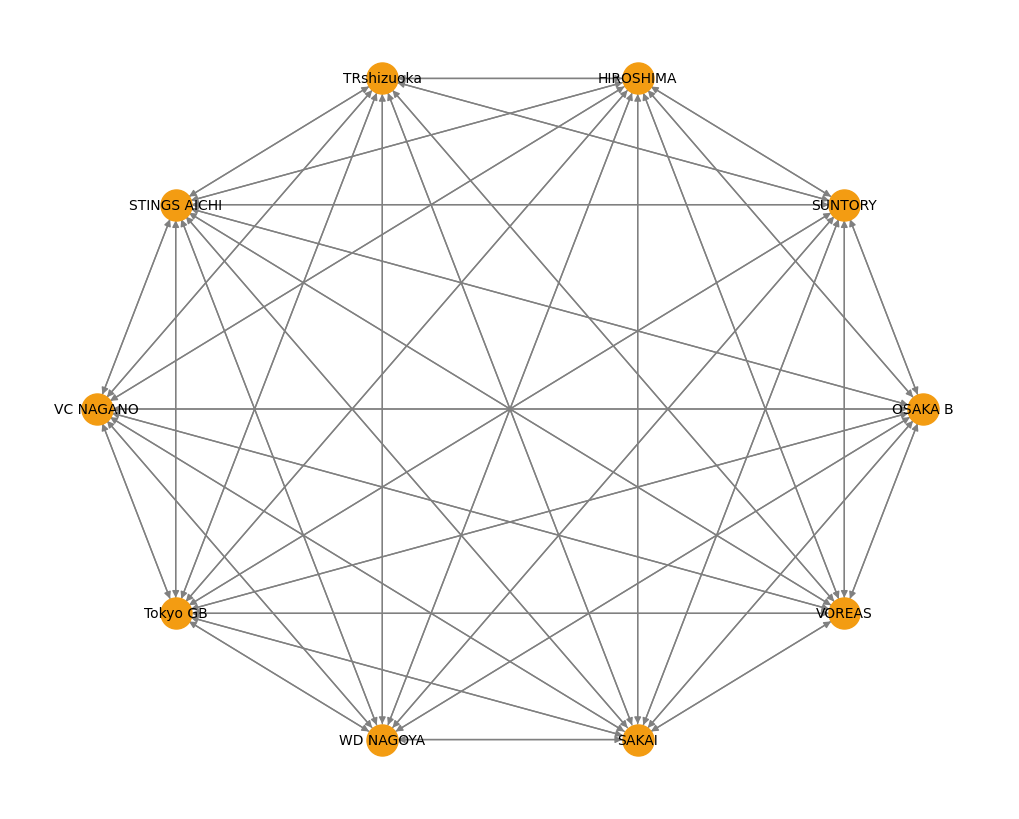

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)  # Positions for visualization
nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, font_color="black", edge_color="gray", node_color="#f39c12")

In [30]:
def predict_score_method1(G, source, target, k=3): # k is the max paths to consider
    paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=k)) # default is dijkstra

    scores = []
    for path in paths:
        path_score = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))

        decay_factor = 1 / ((len(path) - 1) ** 2)  # or np.exp(-len(path))
        scores.append(path_score * decay_factor)

        # dividing by (len(path) - 1) once gives the mean
        # dividing by (len(path) - 1) twice gives the weight

        if len(path) > 3:
            factored_score = (1 / (len(path) - 1) ** function_order) * (path_score ** function_order)
        else:
            factored_score = path_score / (len(path) - 1)

        scores.append(factored_score)

    return np.mean(scores)

function_order = 5 # cubic

def predict_score_method2(G, source, target, k=3): # k is the max paths to consider
    paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=k)) # default is dijkstra

    scores = []

    for path in paths:
        path_score = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))

        if len(path) > 2:
            factored_score = (1 / (len(path) - 1) ** function_order) * (path_score ** function_order)
        else: # path is at least two
            factored_score = path_score / (len(path) - 1)

        scores.append(factored_score)

    return np.mean(scores)

In [31]:
# No weights on the length of the path
def predict_score_method3(G, source, target, k=3): # k is the max paths to consider
    paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=k)) # default is dijkstra

    scores = []
    for path in paths:
        path_score = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))
        scores.append(path_score / (len(path) - 1))

    return np.mean(scores)

# Uses a simple weighted mean (of the additive inverses of the values)
def predict_score_method4(G, source, target, k=3): # k is the max paths to consider
    paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=k)) # default is dijkstra

    scores = defaultdict(list)
    for path in paths:
        path_score = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))
        scores[len(path) - 1].append(path_score / (len(path) - 1))

    path_length_keys = list(scores.keys())

    final_score = 0
    for path_length, score_list in scores.items():
        factor = (max(path_length_keys) + min(path_length_keys) - path_length) / sum(path_length_keys)
        final_score += factor * np.mean(score_list)
        # scores[path_length] = np.mean(score_list)

    return final_score

In [32]:
unfinished_matches_copy = unfinished_matches.copy()
unfinished_matches_copy['predicted_score_method1'] = unfinished_matches_copy.apply(
    lambda row: predict_score_method1(G, source=row['home_team'], target=row['away_team'], k=3), axis=1)
unfinished_matches_copy['predicted_score_method2'] = unfinished_matches_copy.apply(
    lambda row: predict_score_method2(G, source=row['home_team'], target=row['away_team'], k=3), axis=1)
unfinished_matches_copy['predicted_score_method3'] = unfinished_matches_copy.apply(
    lambda row: predict_score_method3(G, source=row['home_team'], target=row['away_team'], k=3), axis=1)
unfinished_matches_copy['predicted_score_method4'] = unfinished_matches_copy.apply(
    lambda row: predict_score_method4(G, source=row['home_team'], target=row['away_team'], k=3), axis=1)

In [33]:
unfinished_matches_copy

,date,home_team,away_team,venue,predicted_score_method1,predicted_score_method2,predicted_score_method3,predicted_score_method4
0,2025-01-18T13:35,VOREAS,SUNTORY,Hakodate Arena,-0.121589,-0.051576,-0.378762,-0.635219
1,2025-01-18T14:05,TRshizuoka,OSAKA B,Koryo Arena,-0.104418,-0.024611,-0.351852,-0.431624
2,2025-01-18T14:05,HIROSHIMA,STINGS AICHI,Higashi-Hiroshima Athletic Park Gymnasium,-0.034850,-0.006954,-0.110169,-0.231944
3,2025-01-18T15:05,Tokyo GB,SAKAI,Ariake Coliseum,0.058856,0.018124,0.169962,0.514398
4,2025-01-18T17:05,WD NAGOYA,VC NAGANO,ENTRIO,0.116002,0.059742,0.332465,0.708841
...,...,...,...,...,...,...,...,...
101,2025-04-12T14:05,VC NAGANO,SUNTORY,ANC Arena,-0.087566,-0.025439,-0.290509,-0.350027
102,2025-04-12T14:05,OSAKA B,TRshizuoka,Panasonic Arena,0.104418,0.024611,0.351852,0.431624
103,2025-04-13T13:05,VC NAGANO,SUNTORY,ANC Arena,-0.087566,-0.025439,-0.290509,-0.350027
104,2025-04-13T13:35,VOREAS,SAKAI,Recruit Staffing RICK&SUE Asahikawa Gymnasium,-0.036219,-0.014713,-0.095650,-0.312669


In [34]:
def normalize(x):
    if x.max() > abs(x.min()):
        return x / x.max()
    else:
        return x / abs(x.min())

In [35]:
columns_to_normalize = ['predicted_score_method1', 'predicted_score_method2', 'predicted_score_method3', 'predicted_score_method4']
unfinished_matches_copy[columns_to_normalize] = unfinished_matches_copy[columns_to_normalize].apply(normalize)

# for column in columns_to_normalize:
#     unfinished_matches_copy[column] = (unfinished_matches_copy[column] - unfinished_matches_copy[column].min()) / (unfinished_matches_copy[column].max() - unfinished_matches_copy[column].min())

In [36]:
unfinished_matches_copy['name'] = unfinished_matches_copy['home_team'] + ' vs ' + unfinished_matches_copy['away_team']
unfinished_matches_copy['name'] = unfinished_matches_copy['name'] + ' (' + unfinished_matches_copy['date'].apply(lambda x: x[5:10]) + ')'

unfinished_matches_copy.sort_values(by='predicted_score_method4', ascending=True, key=abs).head(10)

,date,home_team,away_team,venue,predicted_score_method1,predicted_score_method2,predicted_score_method3,predicted_score_method4,name
46,2025-03-02T14:05,Tokyo GB,OSAKA B,Ariake Coliseum,-0.331733,-0.000119,-0.397267,-0.029248,Tokyo GB vs OSAKA B (03-02)
43,2025-03-01T15:05,Tokyo GB,OSAKA B,Ariake Coliseum,-0.331733,-0.000119,-0.397267,-0.029248,Tokyo GB vs OSAKA B (03-01)
20,2025-02-08T13:05,SUNTORY,WD NAGOYA,Asue Arena Osaka,-0.096233,-0.006056,-0.122999,-0.037084,SUNTORY vs WD NAGOYA (02-08)
25,2025-02-09T13:05,SUNTORY,WD NAGOYA,Asue Arena Osaka,-0.096233,-0.006056,-0.122999,-0.037084,SUNTORY vs WD NAGOYA (02-09)
10,2025-02-01T12:05,SUNTORY,STINGS AICHI,Ookini Arena Maishima,0.137362,0.026338,0.192594,0.043646,SUNTORY vs STINGS AICHI (02-01)
15,2025-02-02T12:05,SUNTORY,STINGS AICHI,Ookini Arena Maishima,0.137362,0.026338,0.192594,0.043646,SUNTORY vs STINGS AICHI (02-02)
87,2025-03-30T14:05,TRshizuoka,VC NAGANO,Konohana Arena,0.004054,-0.047696,0.034084,-0.105886,TRshizuoka vs VC NAGANO (03-30)
81,2025-03-29T14:05,TRshizuoka,VC NAGANO,Konohana Arena,0.004054,-0.047696,0.034084,-0.105886,TRshizuoka vs VC NAGANO (03-29)
27,2025-02-09T14:05,TRshizuoka,SAKAI,Koryo Arena,-0.133917,-0.081453,-0.126159,-0.159797,TRshizuoka vs SAKAI (02-09)
21,2025-02-08T14:05,TRshizuoka,SAKAI,Koryo Arena,-0.133917,-0.081453,-0.126159,-0.159797,TRshizuoka vs SAKAI (02-08)


In [37]:
import matplotlib.pyplot as plt

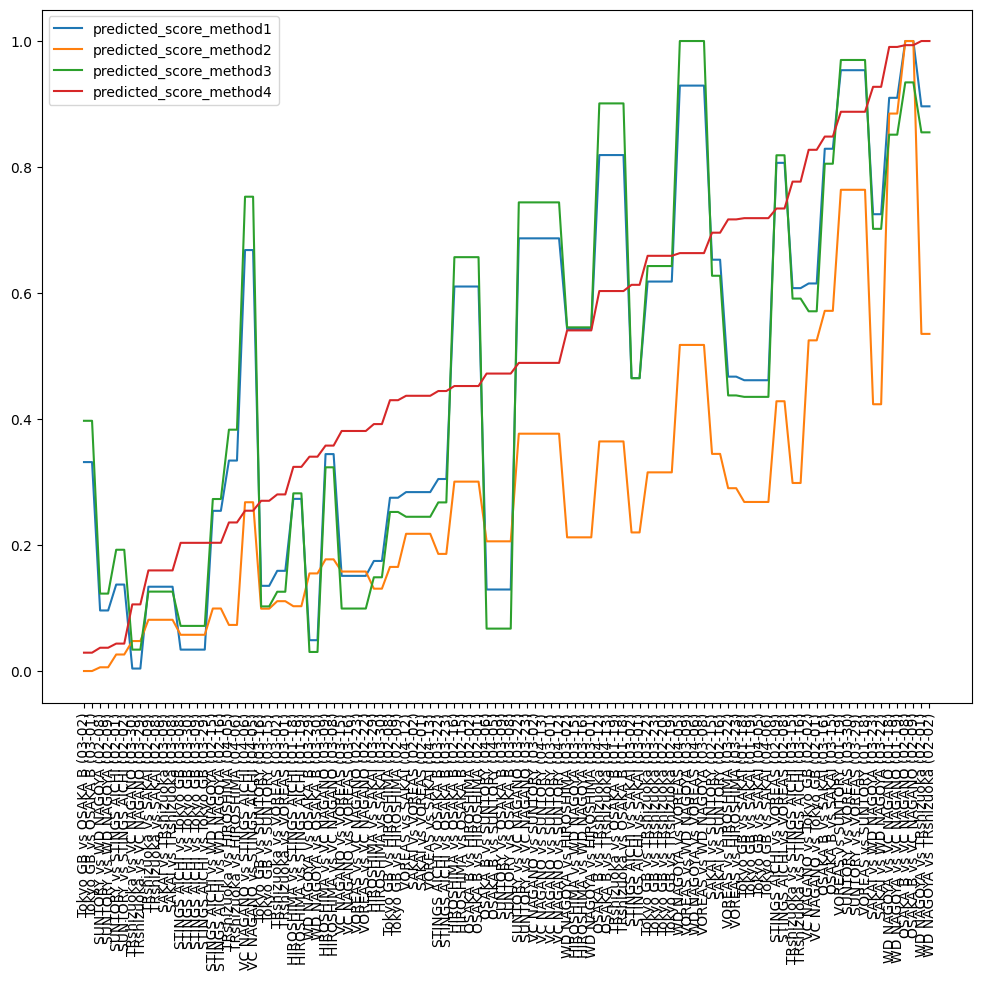

In [38]:
plt.figure(figsize=(12, 9))

sorted_unfinished_matches = unfinished_matches_copy.sort_values(by='predicted_score_method4', ascending=True, key=abs)

plt.plot(sorted_unfinished_matches['name'], abs(sorted_unfinished_matches['predicted_score_method1']), label='predicted_score_method1')
plt.plot(sorted_unfinished_matches['name'], abs(sorted_unfinished_matches['predicted_score_method2']), label='predicted_score_method2')
plt.plot(sorted_unfinished_matches['name'], abs(sorted_unfinished_matches['predicted_score_method3']), label='predicted_score_method3')
plt.plot(sorted_unfinished_matches['name'], abs(sorted_unfinished_matches['predicted_score_method4']), label='predicted_score_method4')

plt.xticks(rotation=90)
plt.legend()
plt.show()

In [39]:
sorted_unfinished_matches

,date,home_team,away_team,venue,predicted_score_method1,predicted_score_method2,predicted_score_method3,predicted_score_method4,name
46,2025-03-02T14:05,Tokyo GB,OSAKA B,Ariake Coliseum,-0.331733,-0.000119,-0.397267,-0.029248,Tokyo GB vs OSAKA B (03-02)
43,2025-03-01T15:05,Tokyo GB,OSAKA B,Ariake Coliseum,-0.331733,-0.000119,-0.397267,-0.029248,Tokyo GB vs OSAKA B (03-01)
20,2025-02-08T13:05,SUNTORY,WD NAGOYA,Asue Arena Osaka,-0.096233,-0.006056,-0.122999,-0.037084,SUNTORY vs WD NAGOYA (02-08)
25,2025-02-09T13:05,SUNTORY,WD NAGOYA,Asue Arena Osaka,-0.096233,-0.006056,-0.122999,-0.037084,SUNTORY vs WD NAGOYA (02-09)
10,2025-02-01T12:05,SUNTORY,STINGS AICHI,Ookini Arena Maishima,0.137362,0.026338,0.192594,0.043646,SUNTORY vs STINGS AICHI (02-01)
...,...,...,...,...,...,...,...,...,...
9,2025-01-19T16:05,WD NAGOYA,VC NAGANO,ENTRIO,0.909879,0.884869,0.851363,0.990611,WD NAGOYA vs VC NAGANO (01-19)
23,2025-02-08T14:05,OSAKA B,VC NAGANO,Panasonic Arena,1.000000,1.000000,0.934351,0.993451,OSAKA B vs VC NAGANO (02-08)
29,2025-02-09T14:05,OSAKA B,VC NAGANO,Panasonic Arena,1.000000,1.000000,0.934351,0.993451,OSAKA B vs VC NAGANO (02-09)
14,2025-02-01T15:35,WD NAGOYA,TRshizuoka,ENTRIO,0.896337,0.535196,0.855068,1.000000,WD NAGOYA vs TRshizuoka (02-01)


In [40]:
sorted_unfinished_matches.to_csv('unfinished_matches_with_scores.csv', index=False)

### Leaderboard Generation

In [41]:
# To evaluate the metrics, let's compare the predicted scores with the differences in leaderboard positions
set_leaderboard_wins = defaultdict(int)
set_leaderboard_losses = defaultdict(int)
match_leaderboard_wins = defaultdict(int)
match_leaderboard_losses = defaultdict(int)

leaderboard = pd.DataFrame(0, columns=['sets_won', 'sets_lost', 'matches_won', 'matches_lost'],
                           index=list(set(finished_matches['winning_team']).union(set(finished_matches['losing_team']))))

for _, row in finished_matches.iterrows():
    winning_team = row['winning_team']
    losing_team = row['losing_team']

    winning_sets = 3
    losing_sets = int(row['score'].split('-')[-1])

    leaderboard.loc[winning_team, 'sets_won'] += winning_sets
    leaderboard.loc[losing_team, 'sets_won'] += losing_sets
    leaderboard.loc[winning_team, 'sets_lost'] += losing_sets
    leaderboard.loc[losing_team, 'sets_lost'] += winning_sets

    leaderboard.loc[winning_team, 'matches_won'] += 1
    leaderboard.loc[losing_team, 'matches_lost'] += 1

In [42]:
leaderboard['set_win_ratio'] = leaderboard['sets_won'] / (leaderboard['sets_won'] + leaderboard['sets_lost'])
leaderboard['match_win_ratio'] = leaderboard['matches_won'] / (leaderboard['matches_won'] + leaderboard['matches_lost'])

leaderboard['mean_win_ratio'] = (leaderboard['set_win_ratio'] + leaderboard['match_win_ratio']) / 2

In [43]:
leaderboard.sort_values(by='mean_win_ratio', ascending=False)

,sets_won,sets_lost,matches_won,matches_lost,set_win_ratio,match_win_ratio,mean_win_ratio
OSAKA B,61,20,19,3,0.753086,0.863636,0.808361
WD NAGOYA,63,30,18,6,0.677419,0.750000,0.713710
SUNTORY,56,28,16,6,0.666667,0.727273,0.696970
STINGS AICHI,55,44,16,8,0.555556,0.666667,0.611111
Tokyo GB,57,39,15,9,0.593750,0.625000,0.609375
HIROSHIMA,43,55,10,14,0.438776,0.416667,0.427721
SAKAI,33,50,7,15,0.397590,0.318182,0.357886
TRshizuoka,31,55,6,16,0.360465,0.272727,0.316596
VC NAGANO,19,57,5,17,0.250000,0.227273,0.238636
VOREAS,23,63,2,20,0.267442,0.090909,0.179175


In [44]:
leaderboard.sort_values(by='mean_win_ratio', ascending=False).to_csv('leaderboard.csv', index=False)

### Checking predicted scores with difference in leaderboard `mean_win_ratio`s

In [45]:
def return_unique_team_combos(df):
    seen_combinations = set()

    unique_indices = []

    for idx, row in df.iterrows():
        team_combination = frozenset([row['home_team'], row['away_team']])

        if team_combination not in seen_combinations:
            seen_combinations.add(team_combination)
            unique_indices.append(idx)

    unique_matches = df.loc[unique_indices]

    unique_matches.reset_index(drop=True, inplace=True)
    return unique_matches

unique_unfinished_matches = return_unique_team_combos(unfinished_matches_copy)

In [46]:
metrics_dict = {f'predicted_score_method{i}': [] for i in range(1, 5)}

for _, row in unique_unfinished_matches.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    diff_mean_ratio = leaderboard.loc[home_team, 'mean_win_ratio'] - leaderboard.loc[away_team, 'mean_win_ratio']
    # Remove the abs to preserve data on which team is better

    for i in range(1, 5):
        predicted_score = row[f'predicted_score_method{i}']
        error = np.sqrt((predicted_score - diff_mean_ratio) ** 2)
        metrics_dict[f'predicted_score_method{i}'].append(error)

for i in range(1, 5):
    print(f'predicted_score_method{i}', np.mean(metrics_dict[f'predicted_score_method{i}']))

predicted_score_method1 0.21067165423912124
predicted_score_method2 0.08262288464134218
predicted_score_method3 0.21400711781834267
predicted_score_method4 0.2681736897738191


In [47]:
mean_metrics = []

for _, row in unique_unfinished_matches.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    diff_mean_ratio = leaderboard.loc[home_team, 'mean_win_ratio'] - leaderboard.loc[away_team, 'mean_win_ratio']

    predicted_score = np.mean([row[f'predicted_score_method{i}'] for i in range(1, 5)])
    error = np.sqrt((predicted_score - diff_mean_ratio) ** 2)
    mean_metrics.append(error)

print('mean predicted score', np.mean(mean_metrics))

mean predicted score 0.1732989368052806


- wonder if you can use a script to get the price / time taken to travel to each of the venues and factor that in.
- then employ a minimization function that calculates the lowest **matches watched / yen** or a similar metric (see if you can plot on matplotlib).


The above approach shouldn't regard **match satisfaction** which is a function of how exciting the volleyball match is. This can be calculated using past match data, or the relative strengths of the teams by showing
- their lank on a leaderboard
- how evenly matched they were with other teams, as per match data
if A evenly matched B and B evenly matched C, then safe to say A is evenly matched with C even though they never played = now do this with ALL past matches and match combinations.
